Copyright (c) 2022 José Ángel de Bustos Pérez

May be copied or modified under the terms of the GNU General Public License v3.0.  See https://www.gnu.org/licenses/gpl-3.0.html

# Training Xception

This notebook trains Xception models and save the best and the last model.

The h5 model is not included due to it exceeds GitHub storage limits.


## Check environment

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)    

print("Tensorflow version: %s\n" % tf.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2022-09-14 22:05:23.299092: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Tensorflow version: 2.5.3

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12946791019166573292
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23002873856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18221588906458059882
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
]
Num GPUs Available:  1


2022-09-14 22:05:24.336169: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-09-14 22:05:24.373762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 22:05:24.373885: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2022-09-14 22:05:24.373905: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-09-14 22:05:24.379354: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-09-14 22:05:24.379396: I tensorflow/stream_executor/pl

## Hyperparameters and data preparation

In [2]:
import numpy as np
import string
import os

whole_dataset = '/home/jadebustos/tfm/datasets/real life violence situations'

video_path_train = '/home/jadebustos/tfm/datasets/video_tmp/full/train'
video_path_validation = '/home/jadebustos/tfm/datasets/video_tmp/full/validation'
video_path_test = '/home/jadebustos/tfm/datasets/video_tmp/full/test'

imgs_path_train = '/home/jadebustos/tfm/datasets/imgs/full-16-frames/train'
imgs_path_validation = '/home/jadebustos/tfm/datasets/imgs/full-16-frames/validation'
imgs_path_test = '/home/jadebustos/tfm/datasets/imgs/full-16-frames/test'

# Hyperparams
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 128
BATCH_SIZE = 16

DROPOUT = 0.5

labels = ['violence', 'nonviolence']
labels_dict = {}
labels_dict['violence'] = 0
labels_dict['nonviolence'] = 1

# get files in directory
def get_files_dir(directory):
    return os.listdir(directory)

files_dir = get_files_dir(os.path.join(video_path_train, 'violence'))
print("Training videos (violence): %d" % len(files_dir))
files_dir = get_files_dir(os.path.join(imgs_path_train, 'violence'))
print("Training images (violence): %d" % len(files_dir))
files_dir = get_files_dir(os.path.join(video_path_train, 'nonviolence'))
print("Training videos (nonviolence): %d" % len(files_dir))
files_dir = get_files_dir(os.path.join(imgs_path_train, 'nonviolence'))
print("Training images (nonviolence): %d" % len(files_dir))

files_dir = get_files_dir(os.path.join(video_path_validation, 'violence'))
print("\nValidation videos (violence): %d" % len(files_dir))
files_dir = get_files_dir(os.path.join(imgs_path_validation, 'violence'))
print("Validation images (violence): %d" % len(files_dir))
files_dir = get_files_dir(os.path.join(video_path_validation, 'nonviolence'))
print("Validation videos (nonviolence): %d" % len(files_dir))
files_dir = get_files_dir(os.path.join(imgs_path_validation, 'nonviolence'))
print("Validation images (nonviolence): %d" % len(files_dir))

files_dir = get_files_dir(os.path.join(video_path_test, 'violence'))
print("\nTest videos (violence): %d" % len(files_dir))
files_dir = get_files_dir(os.path.join(video_path_test, 'nonviolence'))
print("Test videos (nonviolence): %d" % len(files_dir))

Training videos (violence): 600
Training images (violence): 9600
Training videos (nonviolence): 600
Training images (nonviolence): 9600

Validation videos (violence): 200
Validation images (violence): 3200
Validation videos (nonviolence): 200
Validation images (nonviolence): 3200

Test videos (violence): 200
Test videos (nonviolence): 200


Load training and validation data:

In [3]:
import glob
import cv2
from glob import glob

def load_set(dirname, labels_dict, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    labels = glob(os.path.join(dirname, '*'), recursive = False)
    X_ = []
    y_ = []
    
    for label in labels:
        label = label.split('/')[-1]
        dir_path = os.path.join(dirname, label)
        files_path = os.listdir(dir_path)
        images = [file for file in files_path if file.endswith("png")]
        if verbose:
          print("Reading {} images found in {}".format(len(images), files_path))
        for image_name in images:
            image = cv2.imread(os.path.join(dir_path,image_name))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            #X_.append(cv2.resize(image,(IMAGE_WIDTH, IMAGE_HEIGHT)))
            X_.append(image)
            y_.append(labels_dict[label])
    return (np.array(X_).astype('float32'))/255, np.array(y_)

# load data
print("Loading training data ...")
X_train, y_train = load_set(imgs_path_train, labels_dict, verbose=False)
print("Loading validation data ...")
X_validation, y_validation = load_set(imgs_path_validation, labels_dict, verbose=False)

# define input_shape
if tf.keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, IMAGE_WIDTH, IMAGE_HEIGHT)
else:
    input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

Loading training data ...
Loading validation data ...


## Model creation

In [4]:
import time
import tensorflow as tf
import tensorflow.keras as K

# function to get training time (human readable)
def display_time(seconds, granularity=2):
    result = []

    intervals = (
        ('dias', 86400),    # 60 * 60 * 24
        ('horas', 3600),    # 60 * 60
        ('minutos', 60),
        ('segundos', 1),
    )
    
    for name, count in intervals:
        value = seconds // count
        if value:
            seconds -= value * count
            if value == 1:
                name = name.rstrip('s')
            result.append("{} {}".format(value, name))
    return ', '.join(result[:granularity])

# TODO MOVE NEURAL NETWORK CODE TO A CLASS

# load the Keras xception
xception_model = tf.keras.applications.Xception(
    include_top = False,
    weights = 'imagenet',
#    input_tensor = K.Input(shape=input_shape),
    input_shape = input_shape,
)

for layer in xception_model.layers:
    layer.trainable = False

model = K.Sequential()
model.add(xception_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(512, activation="relu"))
model.add(K.layers.Dropout(DROPOUT))
model.add(K.layers.Dense(512, activation="relu"))
model.add(K.layers.Dropout(DROPOUT))
model.add(K.layers.Dense(16, activation="relu"))
model.add(K.layers.Dropout(DROPOUT))
model.add(K.layers.Dense(16, activation="relu"))
model.add(K.layers.Dense(1, activation='sigmoid'))

VERSION="alt3"

model_checkpoint_filename_acc = "trained-xception-b" + str(BATCH_SIZE) + "-e" + str(EPOCHS) + "-16frames-acc-dropout-" + str(DROPOUT) + "-" + VERSION + ".h5"
check_point = K.callbacks.ModelCheckpoint(filepath=model_checkpoint_filename_acc,
                                          monitor="val_accuracy",
                                          mode="max",
                                          save_best_only=True,
                                         )

#early_stopping = K.callbacks.EarlyStopping(monitor='val_accuracy', patience=16, verbose=0, mode='max')

# loss:
#  binary_crossentropy for binary problems
#  categorical_crossentropy for more classes

lr = 1e-6
model.compile(loss='binary_crossentropy',
                 optimizer=K.optimizers.RMSprop(learning_rate=lr),
                  metrics=['accuracy'])

model.summary()

2022-09-14 22:05:49.742397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 22:05:49.742496: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2022-09-14 22:05:49.742539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 22:05:49.742585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 22:05:49.742620: I tensorflow/core/comm

83689472/83683744 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________

## Training the model

Callback to see the model performance. **PlotLossesKeras** from **livelossplot** does not work, it seem a problem with Tensorflow version (2.4.1) and Keras version (2.9.0).

In [5]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [6]:
time.ctime()

'Wed Sep 14 22:05:57 2022'

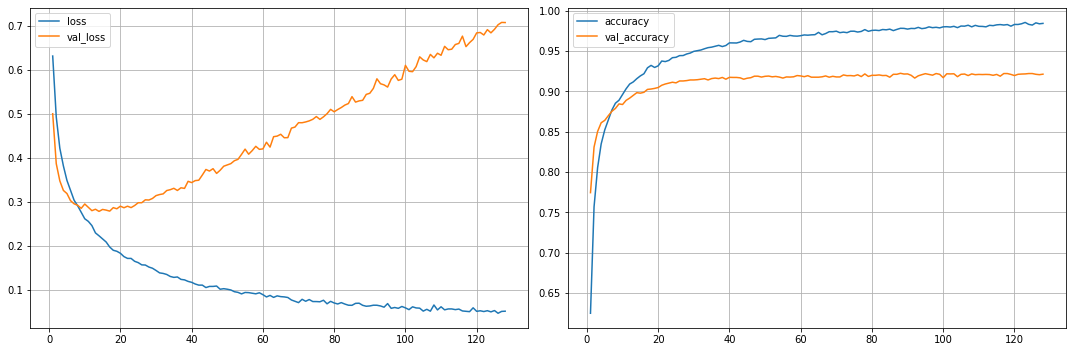

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                8

In [7]:
# time to start training
start_time = time.time()

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                    validation_data=(X_validation, y_validation),
                    shuffle=True,
                    callbacks=[PlotLearning(),
                               check_point])

# time at the end of training
end_time = time.time()

model_last_filename = "trained-xception-b" + str(BATCH_SIZE) + "-e" + str(EPOCHS) + "-16frames-last-dropout-" + str(DROPOUT) + "-" + VERSION + ".h5"

model.summary()
model.save(model_last_filename)

# time to train
msg = display_time(end_time - start_time)
print("Training time: %s" % msg)

In [8]:
accuracy = history.history['accuracy']
max(accuracy)

0.9856250286102295

In [9]:
loss = history.history['loss']
min(loss)

0.04651680588722229

In [10]:
val_accuracy = history.history['val_accuracy']
max(val_accuracy)

0.9225000143051147

In [11]:
val_loss = history.history['val_loss']
min(val_loss)

0.2780204713344574

## Testing the model

In [12]:
prediction = model.predict(X_train[:1])

In [13]:
prediction

array([[4.3124866e-05]], dtype=float32)